In [1]:
import functools
import numpy as np
import copy
from complex_network.networks import network_factory, network_perturbator
from complex_network.networks.network_spec import NetworkSpec
from complex_network.networks import pole_calculator

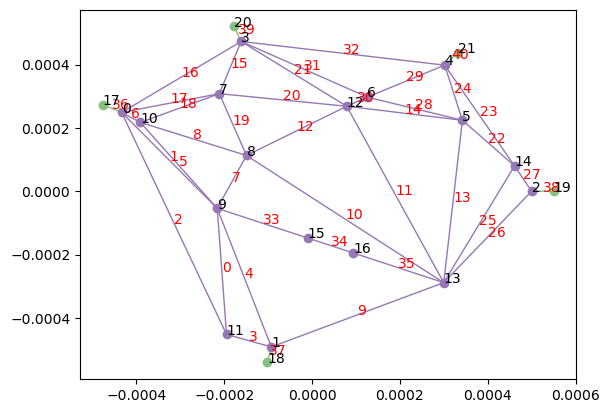

In [2]:
# Generate the random network
np.random.seed(1)
spec = NetworkSpec(
    network_type="delaunay",
    network_shape="circular",
    num_seed_nodes=0,
    external_offset=0.0,
    num_internal_nodes=15,
    num_external_nodes=5,
    network_size=500e-6,
    external_size=550e-6,
    node_S_mat_type="COE",
    node_S_mat_params={},
)
network = network_factory.generate_network(spec)
link_index = 9
network.add_segment_to_link(9, [0.4, 0.6])
network.draw(show_indices=True)
link_index = 34

In [3]:
# Perturb the link and set up matrices
perturbator = network_perturbator.NetworkPerturbator(network)
perturbator.perturb_segment_n(34, 0.1)
network = perturbator.perturbed_network

In [4]:
# Check that refractive index derivative is working properly
n = network.get_link(link_index).n
dn = network.get_link(link_index).dn

dk0 = 0.1

lam0 = 500e-9
k0 = 2 * np.pi / lam0
k1 = k0 + dk0

n0 = n(k0)
n1 = n(k1)

dndk = (n1 - n0) / dk0
theory = dn(k0)

print(f"Calculated: {dndk}")
print(f"Theory: {theory}")
print(f"Difference: {np.abs(theory - dndk)}")

Calculated: 2.645519359134596e-09
Theory: 2.6455192676105925e-09
Difference: 9.152400354495752e-17


In [5]:
lam0 = 500e-9
k0 = 2 * np.pi / lam0 + 1j * np.random.randn()
pole = 11418913.801757216 - 115.61467430443469j

In [6]:
# Calculate the product S^dag S in three different ways

# 1) Formula
S_formula = network.get_S_ee(k0)
prod_formula = np.conj(S_formula.T) @ S_formula

# 2) Volume
U_0 = network.get_U_0_links(k0)
prod_volume = np.identity(len(U_0), dtype=np.complex128) + U_0
S_prod = network.get_S_prod_nodes(k0)
prod_final = prod_volume + S_prod

# Compare
print(
    f"Formula vs Volume without correction: {np.max(np.abs(prod_formula - prod_volume))}"
)
print(f"Formula vs Volume: {np.max(np.abs(prod_formula - prod_final))}")

Formula vs Volume without correction: 2.5675146450021558e-06
Formula vs Volume: 2.664535290656709e-15


In [7]:
S_formula = network.get_S_ee(k0)
prod_formula = np.conj(S_formula.T) @ S_formula
print(prod_formula)


[[ 9.91803001e-01+0.00000000e+00j  3.59239096e-03-1.12822955e-03j
   9.24587754e-04+1.31623334e-03j -1.91556423e-03-1.09685311e-03j
  -1.47744359e-03+5.25561417e-04j]
 [ 3.59239096e-03+1.12822955e-03j  9.90349500e-01+0.00000000e+00j
  -4.91276912e-04-3.07180037e-03j  1.17434458e-04-4.12576337e-04j
   2.16582020e-03+1.50560249e-04j]
 [ 9.24587754e-04-1.31623334e-03j -4.91276912e-04+3.07180037e-03j
   9.98103372e-01+0.00000000e+00j -2.10682081e-05+2.55635344e-05j
   6.52511927e-04-1.27248930e-03j]
 [-1.91556423e-03+1.09685311e-03j  1.17434458e-04+4.12576337e-04j
  -2.10682081e-05-2.55635344e-05j  9.98473732e-01+0.00000000e+00j
  -8.83878857e-05+1.00109882e-04j]
 [-1.47744359e-03-5.25561417e-04j  2.16582020e-03-1.50560249e-04j
   6.52511927e-04+1.27248930e-03j -8.83878857e-05-1.00109882e-04j
   9.97375588e-01+0.00000000e+00j]]


In [8]:
# Calculate k0 Wigner Smith operator directly and using volume integrals

ws_direct = network.get_wigner_smith(k0)
ws_volume = network.get_wigner_smith_volume(k0)
difference = ws_volume - ws_direct

# Compare
print(f"Difference: {np.max(np.abs(difference))}")
print(f"Smallest value: {np.min(np.abs(ws_direct))}")
print(f"Ratio: {np.max(np.abs(difference)) / np.min(np.abs(ws_direct))}")

Difference: 3.259960580275736e-16
Smallest value: 4.834989575843275e-05
Ratio: 6.742435591926097e-12


In [9]:
# Calculate Dn Wigner Smith operator directly and using volume integrals

ws_direct = network.get_wigner_smith(k0, "Dn", perturbed_link_index=link_index)
ws_volume = network.get_wigner_smith_volume(
    k0, "Dn", perturbed_link_index=link_index
)
difference = ws_volume - ws_direct

print(f"Difference: {np.max(np.abs(difference))}")
print(f"Smallest value: {np.min(np.abs(ws_direct))}")
print(f"Ratio: {np.max(np.abs(difference)) / np.min(np.abs(ws_direct))}")

Difference: 9.79248129388755e-10
Smallest value: 26.154648759882434
Ratio: 3.7440691265974265e-11


In [10]:
# Calculate trace of residue of k0 Wigner Smith operator directly and
# using volume integrals at the pole

res_direct = pole_calculator.get_residue(network.get_wigner_smith, pole)
trace_direct = np.trace(res_direct)

res_volume = pole_calculator.get_residue(network.get_wigner_smith_volume, pole)
trace_volume = np.trace(res_volume)

difference = trace_direct - trace_volume

# Compare
print(f"Difference: {np.max(np.abs(difference))}")
print(f"Smallest value: {np.min(np.abs(trace_direct))}")
print(f"Ratio: {np.max(np.abs(difference)) / np.min(np.abs(trace_direct))}")
print(f"Residue trace: {trace_direct}")

Difference: 1.5265635845499744e-10
Smallest value: 1.0090227047387148
Ratio: 1.5129130171013111e-10
Residue trace: (-1.0619404872402871e-06+1.009022704738156j)


In [11]:
# Calculate trace of residue of k0 Wigner Smith operator directly and
# using volume integrals at the pole

# Define functions to calculate residues for
direct_func = functools.partial(
    network.get_wigner_smith, variable="Dn", perturbed_link_index=link_index
)
volume_func = functools.partial(
    network.get_wigner_smith_volume,
    variable="Dn",
    perturbed_link_index=link_index,
)

res_direct = pole_calculator.get_residue(direct_func, pole)
trace_direct = np.trace(res_direct)
res_volume = pole_calculator.get_residue(volume_func, pole)
trace_volume = np.trace(res_volume)

difference = trace_direct - trace_volume

# Compare
print(f"Difference: {np.max(np.abs(difference))}")
print(f"Smallest value: {np.min(np.abs(trace_direct))}")
print(f"Ratio: {np.max(np.abs(difference)) / np.min(np.abs(trace_direct))}")
print(f"Residue trace: {trace_direct}")

Difference: 1.0889132817410074e-06
Smallest value: 14775.177840930155
Ratio: 7.36988274161075e-11
Residue trace: (14585.439731406308+2360.2601705379348j)


In [12]:
# Compare ratio of traces to ratio of residues with direct method

# Matrices
ws_direct_k0 = network.get_wigner_smith(pole)
ws_direct_Dn = network.get_wigner_smith(
    pole, "Dn", perturbed_link_index=link_index
)
trace_direct_k0 = np.trace(ws_direct_k0)
trace_direct_Dn = np.trace(ws_direct_Dn)
ratio_direct = trace_direct_k0 / trace_direct_Dn

# Residues
res_direct_k0 = pole_calculator.get_residue(network.get_wigner_smith, pole)
res_trace_direct_k0 = np.trace(res_direct_k0)

direct = functools.partial(
    network.get_wigner_smith, variable="Dn", perturbed_link_index=link_index
)
res_direct_Dn = pole_calculator.get_residue(direct, pole)
res_trace_direct_Dn = np.trace(res_direct_Dn)
ratio_res_direct = res_trace_direct_k0 / res_trace_direct_Dn

difference = ratio_direct - ratio_res_direct

# Compare
print(f"Difference: {np.max(np.abs(difference))}")
print(f"Smallest value: {np.min(np.abs(ratio_direct))}")
print(f"Ratio: {np.max(np.abs(difference)) / np.min(np.abs(ratio_direct))}")
print(f"Residue trace k0: {res_trace_direct_k0}")
print(f"Residue trace Dn: {res_trace_direct_Dn}")

Difference: 6.946742682794094e-11
Smallest value: 6.829179195060861e-05
Ratio: 1.0172148781537699e-06
Residue trace k0: (-1.0619404872402871e-06+1.009022704738156j)
Residue trace Dn: (14585.439731406308+2360.2601705379348j)


In [13]:
# Compare ratio of traces to ratio of residues with volume method

# Matrices
ws_volume_k0 = network.get_wigner_smith_volume(pole)
ws_volume_Dn = network.get_wigner_smith_volume(
    pole, "Dn", perturbed_link_index=link_index
)
trace_volume_k0 = np.trace(ws_volume_k0)
trace_volume_Dn = np.trace(ws_volume_Dn)
ratio_volume = trace_volume_k0 / trace_volume_Dn

# Residues
res_volume_k0 = pole_calculator.get_residue(
    network.get_wigner_smith_volume, pole
)
res_trace_volume_k0 = np.trace(res_volume_k0)
func = functools.partial(
    network.get_wigner_smith_volume,
    variable="Dn",
    perturbed_link_index=link_index,
)
res_volume_Dn = pole_calculator.get_residue(func, pole)
res_trace_volume_Dn = np.trace(res_volume_Dn)
ratio_res_volume = res_trace_volume_k0 / res_trace_volume_Dn

difference = ratio_volume - ratio_res_volume

# Compare
print(f"Difference: {np.max(np.abs(difference))}")
print(f"Smallest value: {np.min(np.abs(ratio_direct))}")
print(f"Ratio: {np.max(np.abs(difference)) / np.min(np.abs(ratio_direct))}")

Difference: 9.036858661675371e-05
Smallest value: 6.829179195060861e-05
Ratio: 1.3232715680108662


In [14]:
# Compare matrix methods direct vs volume
difference = ratio_direct - ratio_volume
print(f"Difference: {np.max(np.abs(difference))}")
print(f"Smallest value: {np.min(np.abs(ratio_direct))}")
print(f"Ratio: {np.max(np.abs(difference)) / np.min(np.abs(ratio_direct))}")

# Compare residue methods direct vs volume
difference = ratio_res_direct - ratio_res_volume
print(f"Difference: {np.max(np.abs(difference))}")
print(f"Smallest value: {np.min(np.abs(ratio_res_direct))}")
print(f"Ratio: {np.max(np.abs(difference)) / np.min(np.abs(ratio_res_direct))}")

Difference: 9.036864651220469e-05
Smallest value: 6.829179195060861e-05
Ratio: 1.323272445062841
Difference: 7.385006615920359e-15
Smallest value: 6.82917468474405e-05
Ratio: 1.0813907912500764e-10


In [15]:
print(ratio_direct)
print(ratio_volume)
print(ratio_res_direct)
print(ratio_res_volume)

(1.0909146362894535e-05+6.74148305156822e-05j)
(2.6415922180921537e-05-2.1613435648369648e-05j)
(1.0909191313452903e-05+6.741477755182007e-05j)
(1.090919130794367e-05+6.741477754690207e-05j)
